# Computing the instanton of the Maier-Stein system

## Import statements

In [1]:
# Modify path environment variables to search for the local Pyritz and NLopt installations in the repository.

import os, sys

pyritz_dir = "/".join(os.getcwd().split("/")[:-2])
nlopt_lib_dir = ":%s/nlopt/lib" % pyritz_dir
nlopt_py_dir = "%s/nlopt/nlopt_py" % pyritz_dir

os.environ['LD_LIBRARY_PATH'] = nlopt_lib_dir + os.environ['LD_LIBRARY_PATH']
sys.path.insert(0, nlopt_py_dir)
sys.path.insert(0, pyritz_dir)

# Import statements

import pyritz

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import nlopt

## Define system

#### System:

$$
dX = a(X)dt + \sqrt{\epsilon} dW.
$$

where $x = (u, v)$ and

$$
a(u, v) =
\begin{pmatrix}
u - u^3 - \beta u v^2 \\
-(1 + u^2) v
\end{pmatrix}
$$

and

$$
\nabla a = \begin{pmatrix}
    1 - 3 u^2 - \beta v^2 &  -2 u v \\
    - 2 \beta u v & - (1 + u^2)
\end{pmatrix}
$$

where $(\nabla a)_{ij} = \frac{\partial a_i}{\partial x_j}$.

#### Lagrangian:

$$
L(x, \dot x) = |\dot x| |a(x)| - \dot x \cdot a(x)
$$

#### Derivatives of the Lagrangian:

$$\begin{aligned}
\frac{\partial L}{\partial x} & = \nabla a( x ) \cdot \left( |\dot x| \hat{a}(x) - \dot x \right) \\
\frac{\partial L}{\partial \dot x} & = |a(x)| \hat{\dot{x}} - a(x)
\end{aligned}$$

In [2]:
# System parameters

m_beta = 10

# Fixed points

e_xa = np.array([-1, 0])
e_xb = np.array([1,  0])
e_xs = np.array([0,  0])

# System Lagrangian

def system_a(u, v):
    return np.array([u - np.power(u, 3) - m_beta * u * np.power(v, 2), -(1 + np.power(u, 2))*v])

def lagrangian(ls, dxls, dvls, path, ts, args):
    xs, dxs = path
    
    sas = system_a(xs[0, :], xs[1, :])
    dx_norms = np.linalg.norm(dxs, axis=0)
    sa_norms = np.linalg.norm(sas, axis=0)
    dxs_dot_sas = dxs[0, :]*sas[0, :] + dxs[1, :]*sas[1, :]
    
    ls[:] = dx_norms * sa_norms - dxs_dot_sas
    
    if not dxls is None:

        ## Compute dL/dx

        da = np.array([
            [1 - 3*xs[0,:]**2 - m_beta*xs[1,:]**2,     -2*xs[0,:]*xs[1,:]],
            [-2*m_beta*xs[0,:]*xs[1,:],                -(1+xs[0,:]**2)]
        ])

        f = np.where(sa_norms!=0)
        sa_units = np.zeros(sas.shape)
        sa_units[:, f] = sas[:, f]/sa_norms[f]

        for i in range(len(ls)):
            dxls[:, i] = da[:,:,i].dot( dx_norms[i]*sa_units[:,i] - dxs[:,i])

        ## Compute dL/dv

        f = np.where(dx_norms!=0)
        adxs = np.zeros(dxs.shape)
        adxs[:, f] = dxs[:, f]*sa_norms[f]/dx_norms[f]

        dvls[:] = adxs - sas

## Computing the instanton

### Gradient-based optimisation

In [9]:
x1 = e_xa
x2 = e_xb

n = 8
nq = n*10

path = pyritz.interpolation.Path(lagrangian, n, nq, x1, x2)
alpha0 = pyritz.interpolation.utils.linear_path(x1, x2, n)
alpha0 += np.random.random(len(alpha0))*0.1 # Add random noise to the initial path

opt = nlopt.opt(nlopt.LD_SLSQP, np.size(alpha0))
opt.set_min_objective(path.action)
opt.set_xtol_rel(1e-16)
alpha = opt.optimize(alpha0)

print("S[alpha0] = %s" % path.action(alpha0))
print("S[alpha]  = %s" % path.action(alpha))

S[alpha0] = 0.5256757369575336
S[alpha]  = 0.34005247048810444


#### Instanton plot

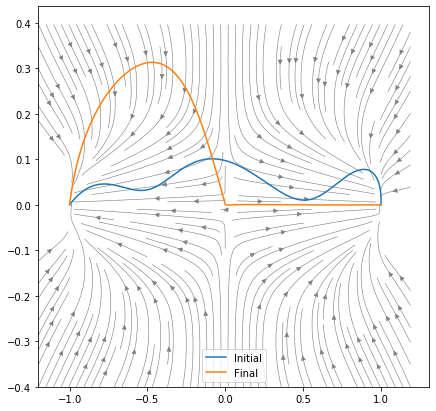

In [4]:
ts = np.linspace(-1, 1, 1000)

paths = [
    (path.get_alpha_with_endpoints(alpha0), "Initial"),
    (path.get_alpha_with_endpoints(alpha), "Final")
]

for _alpha, _label in paths:
    xs = pyritz.interpolation.utils.interpolate(_alpha, n, ts)
    plt.plot(xs[0,:], xs[1,:], label=_label)

X, Y = np.meshgrid(np.linspace(-1.2,1.2,64), np.linspace(-0.4,.4,64))
sax,say=system_a(X,Y); sax=sax/np.sqrt(sax**2+say**2); say=say/np.sqrt(sax**2+say**2)
plt.streamplot(X,Y, sax, say, density=1.7, linewidth=.6, color='gray');
plt.legend()

fig = mpl.pyplot.gcf()
fig.set_size_inches(7, 7)

### Gradient-free optimisation

In [5]:
x1 = e_xa
x2 = e_xb

n = 8
nq = n*10

path = pyritz.interpolation.Path(lagrangian, n, nq, x1, x2)
alpha0 = pyritz.interpolation.utils.linear_path(x1, x2, n)

def get_action(alpha, grad):
    return path.action(alpha)

opt = nlopt.opt(nlopt.LN_NEWUOA, np.size(alpha0))
opt.set_min_objective(get_action)
opt.set_xtol_rel(1e-16)
alpha = opt.optimize(alpha0)

print("S[alpha0] = %s" % path.action(alpha0))
print("S[alpha]  = %s" % path.action(alpha))

S[alpha0] = 0.4997429110421533
S[alpha]  = 0.49974291104215324


#### Instanton plot

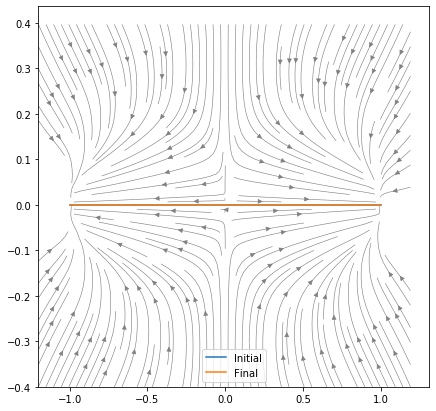

In [6]:
ts = np.linspace(-1, 1, 1000)

paths = [
    (path.get_alpha_with_endpoints(alpha0), "Initial"),
    (path.get_alpha_with_endpoints(alpha), "Final")
]

for _alpha, _label in paths:
    xs = pyritz.interpolation.utils.interpolate(_alpha, n, ts)
    plt.plot(xs[0,:], xs[1,:], label=_label)

X, Y = np.meshgrid(np.linspace(-1.2,1.2,64), np.linspace(-0.4,.4,64))
sax,say=system_a(X,Y); sax=sax/np.sqrt(sax**2+say**2); say=say/np.sqrt(sax**2+say**2)
plt.streamplot(X,Y, sax, say, density=1.7, linewidth=.6, color='gray');
plt.legend()

fig = mpl.pyplot.gcf()
fig.set_size_inches(7, 7)